In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/datasets/covidct/train")

Resolving data files:   0%|          | 0/1148 [00:00<?, ?it/s]

Using custom data configuration default-a035a27d119c8982
Reusing dataset image_folder (/root/.cache/huggingface/datasets/image_folder/default-a035a27d119c8982/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1148
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 1148
})

In [ ]:
dataset['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=2, names=['ncov', 'no_ncov'], id=None)}

In [ ]:
example = dataset["train"][0]
type(example)
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=270x164 at 0x7F63B7214B90>,
 'label': 0}

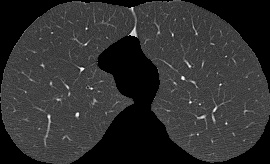

In [ ]:
example["image"]

In [ ]:
example["label"]

0

In [ ]:
labels = dataset["train"].features["label"].names
print(labels)

['ncov', 'no_ncov']


In [ ]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'ncov', 1: 'no_ncov'}


In [ ]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

# applying transformmations according to convnext defination

In [ ]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose(
    [
     RandomResizedCrop(feature_extractor.size),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]

  return examples


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1148
    })
})

In [ ]:
# if we use map instead of with_transform it will transform on runtime but
# with_transform transforms on fly time (when data is reuired)

processed_dataset = dataset.with_transform(train_transforms)

In [ ]:
processed_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=270x164 at 0x7F63B7237310>,
 'label': 0,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1008, -2.1008],
          ...,
          [-0.9534, -0.9877, -1.0390,  ..., -2.1179, -2.1179, -2.1179],
          [-0.9534, -0.9534, -0.9534,  ..., -2.1179, -2.1179, -2.1179],
          [-0.9534, -0.9534, -0.9363,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0182, -2.0182],
          ...,
          [-0.8452, -0.8803, -0.9328,  ..., -2.0357, -2.0357, -2.0357],
          [-0.8452, -0.8452, -0.8452,  ..., -2.0357, -2.0357, -2.0357],
          [-0.8452, -0.8452, -0.8277,  ..., -2.0357, 

In [ ]:
processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 224, 224])

## defining model
from hugging face

In [ ]:
len(labels)

2

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)
# ignore_mismatched_sizes=True it basically removes the classification head of calling model


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Moving to processing unit

In [ ]:
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [ ]:
from torch.utils.data import DataLoader

# because we need only pixel values and labels
def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=64, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)


  # these four are only used as parameter in convnext model

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Train the model

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# tqdm is used to track the proress of training
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
number_of_epochs=30
model.train()
for epoch in range(number_of_epochs):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])
    
    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

Epoch: 0


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.6345035433769226
Accuracy after 0 steps: 0.5
Loss after 100 steps: 0.38970085978507996
Accuracy after 100 steps: 0.6955445544554455
Loss after 200 steps: 0.91866135597229
Accuracy after 200 steps: 0.7699004975124378
Epoch: 1


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.309212327003479
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.3753548264503479
Accuracy after 100 steps: 0.8193069306930693
Loss after 200 steps: 0.23111426830291748
Accuracy after 200 steps: 0.832089552238806
Epoch: 2


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.5564351677894592
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.1515362709760666
Accuracy after 100 steps: 0.8539603960396039
Loss after 200 steps: 0.0771738588809967
Accuracy after 200 steps: 0.8569651741293532
Epoch: 3


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.6181458234786987
Accuracy after 0 steps: 0.5
Loss after 100 steps: 0.3426813781261444
Accuracy after 100 steps: 0.8539603960396039
Loss after 200 steps: 0.06743361800909042
Accuracy after 200 steps: 0.8681592039800995
Epoch: 4


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.17365756630897522
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.19854779541492462
Accuracy after 100 steps: 0.8787128712871287
Loss after 200 steps: 0.0903385728597641
Accuracy after 200 steps: 0.8805970149253731
Epoch: 5


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.4940783977508545
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.03177075460553169
Accuracy after 100 steps: 0.8960396039603961
Loss after 200 steps: 0.086028553545475
Accuracy after 200 steps: 0.8917910447761194
Epoch: 6


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.08391429483890533
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.13916969299316406
Accuracy after 100 steps: 0.8688118811881188
Loss after 200 steps: 0.10167098045349121
Accuracy after 200 steps: 0.8868159203980099
Epoch: 7


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.7464858293533325
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.9828442335128784
Accuracy after 100 steps: 0.9034653465346535
Loss after 200 steps: 0.06089840829372406
Accuracy after 200 steps: 0.9079601990049752
Epoch: 8


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.16542373597621918
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.2891208529472351
Accuracy after 100 steps: 0.9183168316831684
Loss after 200 steps: 0.20912624895572662
Accuracy after 200 steps: 0.9054726368159204
Epoch: 9


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.1939617246389389
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.043304625898599625
Accuracy after 100 steps: 0.9504950495049505
Loss after 200 steps: 0.07632174342870712
Accuracy after 200 steps: 0.9490049751243781
Epoch: 10


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.17253530025482178
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.07817848026752472
Accuracy after 100 steps: 0.9405940594059405
Loss after 200 steps: 0.2639062702655792
Accuracy after 200 steps: 0.9390547263681592
Epoch: 11


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.14074483513832092
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.08146832138299942
Accuracy after 100 steps: 0.9257425742574258
Loss after 200 steps: 0.10678556561470032
Accuracy after 200 steps: 0.9129353233830846
Epoch: 12


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.016682744026184082
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.20356620848178864
Accuracy after 100 steps: 0.9504950495049505
Loss after 200 steps: 0.08957211673259735
Accuracy after 200 steps: 0.9390547263681592
Epoch: 13


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.30282244086265564
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.011483674868941307
Accuracy after 100 steps: 0.948019801980198
Loss after 200 steps: 0.017602819949388504
Accuracy after 200 steps: 0.9490049751243781
Epoch: 14


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.012070647440850735
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.29373082518577576
Accuracy after 100 steps: 0.948019801980198
Loss after 200 steps: 0.22221219539642334
Accuracy after 200 steps: 0.9527363184079602
Epoch: 15


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.05496396869421005
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.009394299238920212
Accuracy after 100 steps: 0.9207920792079208
Loss after 200 steps: 0.05774740129709244
Accuracy after 200 steps: 0.9390547263681592
Epoch: 16


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.0016820230521261692
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.17741554975509644
Accuracy after 100 steps: 0.9727722772277227
Loss after 200 steps: 0.0012141806073486805
Accuracy after 200 steps: 0.9589552238805971
Epoch: 17


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.3702930212020874
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.0058142757043242455
Accuracy after 100 steps: 0.9529702970297029
Loss after 200 steps: 0.17678393423557281
Accuracy after 200 steps: 0.9577114427860697
Epoch: 18


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.3410969376564026
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.0240098237991333
Accuracy after 100 steps: 0.9529702970297029
Loss after 200 steps: 0.03362231329083443
Accuracy after 200 steps: 0.9490049751243781
Epoch: 19


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.029178321361541748
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.36575666069984436
Accuracy after 100 steps: 0.9529702970297029
Loss after 200 steps: 0.1140696331858635
Accuracy after 200 steps: 0.9490049751243781
Epoch: 20


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.0029855710454285145
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.04867437854409218
Accuracy after 100 steps: 0.9851485148514851
Loss after 200 steps: 0.030036363750696182
Accuracy after 200 steps: 0.9751243781094527
Epoch: 21


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.6181502938270569
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.0517941378057003
Accuracy after 100 steps: 0.9554455445544554
Loss after 200 steps: 0.023888276889920235
Accuracy after 200 steps: 0.9626865671641791
Epoch: 22


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.0014162299921736121
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0002990179928019643
Accuracy after 100 steps: 0.9653465346534653
Loss after 200 steps: 0.04032072052359581
Accuracy after 200 steps: 0.9601990049751243
Epoch: 23


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.003581192810088396
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.07642363011837006
Accuracy after 100 steps: 0.9603960396039604
Loss after 200 steps: 0.0839013159275055
Accuracy after 200 steps: 0.9514925373134329
Epoch: 24


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.006639673374593258
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0010013150749728084
Accuracy after 100 steps: 0.9554455445544554
Loss after 200 steps: 0.16593389213085175
Accuracy after 200 steps: 0.9502487562189055
Epoch: 25


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.00040487965452484787
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.00047642813296988606
Accuracy after 100 steps: 0.9653465346534653
Loss after 200 steps: 0.08038127422332764
Accuracy after 200 steps: 0.9502487562189055
Epoch: 26


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.018492449074983597
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.006360851228237152
Accuracy after 100 steps: 0.9678217821782178
Loss after 200 steps: 0.03226097673177719
Accuracy after 200 steps: 0.9664179104477612
Epoch: 27


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.0004383647465147078
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0003537662560120225
Accuracy after 100 steps: 0.9777227722772277
Loss after 200 steps: 0.0003601125499699265
Accuracy after 200 steps: 0.9763681592039801
Epoch: 28


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.004651171155273914
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.10668492317199707
Accuracy after 100 steps: 0.9801980198019802
Loss after 200 steps: 0.006567421834915876
Accuracy after 200 steps: 0.9763681592039801
Epoch: 29


  0%|          | 0/287 [00:00<?, ?it/s]

Loss after 0 steps: 0.04784688726067543
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.05933692306280136
Accuracy after 100 steps: 0.9777227722772277
Loss after 200 steps: 0.009464362636208534
Accuracy after 200 steps: 0.9664179104477612


# push to hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
repo_name = "Waleed-bin-Qamar/Name_you_want_to_allot"               # "hugging repo name as i have written mine / new name"

model.push_to_hub(repo_name)


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='ConvNext-For-Covid-Classification-30EP' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:676: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Walidabbas/ConvNext-For-Covid-Classification-30EP into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/106M [00:00<?, ?B/s]

To https://huggingface.co/Walidabbas/ConvNext-For-Covid-Classification-30EP
   a2fa971..98cec89  main -> main



'https://huggingface.co/Walidabbas/ConvNext-For-Covid-Classification-30EP/commit/98cec89e95ec2572e5d8532828d056ec64c5a2da'

In [ ]:
feature_extractor.push_to_hub("Waleed-bin-Qamar/Name_you_want_to_allot")

To https://huggingface.co/Walidabbas/ConvNext-For-Covid-Classification-30EP
   98cec89..87de07e  main -> main



'https://huggingface.co/Walidabbas/ConvNext-For-Covid-Classification-30EP/commit/87de07e7431f3adccb4812a68e98edc1d552507b'

# inference

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("Waleed-bin-Qamar/Name_you_want_to_allot")
model = AutoModelForImageClassification.from_pretrained("Waleed-bin-Qamar/Name_you_want_to_allot")



# testing

In [ ]:
test_dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/datasets/covidct/test")    # test dir path need to update


Resolving data files:   0%|          | 0/567 [00:00<?, ?it/s]

Using custom data configuration default-91c1e368064bba73
Reusing dataset image_folder (/root/.cache/huggingface/datasets/image_folder/default-91c1e368064bba73/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
test_dataset

DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 567
    })
})

In [ ]:
test_dataset['test']

Dataset({
    features: ['image', 'label'],
    num_rows: 567
})

In [ ]:
test_dataset['test'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=2, names=['ncov', 'no_ncov'], id=None)}

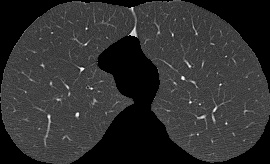

In [ ]:
example["image"]


# TESTING LOOP

In [ ]:
example["label"]

0

In [ ]:
import torch
j,TP,TN,FN,FP=0,0,0,0,0


for j in range(567):
  sample = test_dataset["test"][j]
  image_sample = sample["image"]
  label_sample = sample["label"]
  # print(label_sample)
  
  if label_sample == 0:
    label_sample='ncov'
  else:
    label_sample='no-ncov'
    
  # print(type(label_sample))
  # print(label_sample)
  sample_pixel_values= feature_extractor(image_sample.convert("RGB"), return_tensors="pt").pixel_values
  # print(sample_pixel_values.shape)
  
    
  with torch.no_grad():
    sample_outputs = model(sample_pixel_values)
    logits = sample_outputs.logits
   
  # print(logits.shape)
  predicted_class_idx = logits.argmax(-1).item()
  # print(model.config.id2label[predicted_class_idx])
  label_output=model.config.id2label[predicted_class_idx]
  # print(type(label_output))
  
  if label_output == label_sample== 'ncov':
    TP = TP +1
  elif label_output == label_sample == 'no-ncov':
    TN = TN+1
  elif len(label_output) < len(label_sample):
    FP = FP+1
  else:
    FN =FN+1
    


    


print("TP = ",TP)
print("TN = ", TN)
print("FP = ", FP)
print("FN =", FN)


TP =  355
TN =  0
FP =  74
FN = 138


In [ ]:
acc=  (TP + TN) / (TP + TN + FP + FN)
pre= TP/(TP+FP)
re= TP/(TP+FN)
f1= (2*(pre * re))/(pre + re)
print("ACCURACY = ",acc)
print("PRECISION = ",pre)
print("RECALL = ",re)
print("F1-MEASURE = ",f1)

ACCURACY =  0.6261022927689595
PRECISION =  0.8275058275058275
RECALL =  0.7200811359026369
F1-MEASURE =  0.7700650759219088
